# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [133]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [134]:
!wget -P content https://github.com/PiginIvan/Archives/raw/main/tweets_coronavirus.csv

--2024-05-13 19:56:18--  https://github.com/PiginIvan/Archives/raw/main/tweets_coronavirus.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PiginIvan/Archives/main/tweets_coronavirus.csv [following]
--2024-05-13 19:56:19--  https://raw.githubusercontent.com/PiginIvan/Archives/main/tweets_coronavirus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8829280 (8.4M) [text/plain]
Saving to: ‘content/tweets_coronavirus.csv.2’

tweets_coronavirus. 100%[===================>]   8.42M  --.-KB/s    in 0.09s   

2024-05-13 19:56:19 (94.7 MB/s) - ‘content/tweets_coronavirus.csv.2’ saved [8829280/882928

In [135]:
df = pd.read_csv('content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4212,8919,53871,visakhapatnam,18-03-2020,#Paracetamol is the first line medicine to cur...,Extremely Negative
33107,44526,89478,"Seattle, WA",13-04-2020,Now Available via @FMI_ORG (The Food Industry ...,Positive
29380,39856,84808,UDINE,09-04-2020,via del Boschetto Customers queuing to enter t...,Positive
20864,29244,74196,NaN,31-03-2020,Of course govt realises it needs migrants ?. J...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [136]:
target_map = {'Positive': 1, 'Extremely Positive': 1, 'Negative': 0, 'Extremely Negative': 0}
df['Sentiment'] = df['Sentiment'].map(target_map)

Сбалансированы ли классы?

In [137]:
pd.DataFrame(df['Sentiment'].value_counts())

,count
Sentiment,
1,18046
0,15398


**Ответ:** **классы неплохо сбалансированны, так как позитивных отзывов `18046`, а негативных - `15398`, разница в значениях незначительна.**

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [138]:
print('Есть ли в датасете пропуски?', "Да" if np.any(df.isna().values) else "Нет")

df.fillna("Unknown", inplace=True)

print('Есть ли в датасете пропуски?', "Да" if np.any(df.isna().values) else "Нет")

Есть ли в датасете пропуски? Да
Есть ли в датасете пропуски? Нет


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [139]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=0, test_size=0.3)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [140]:
from collections import Counter

train_tokens = train['OriginalTweet'].str.lower().str.split()
train_tokens_dict = Counter()

for token in train_tokens:
    train_tokens_dict.update(token)
train_tokens_dict = dict(train_tokens_dict)

Какой размер словаря получился?

In [141]:
print('Размер словаря:', len(train_tokens_dict))

Размер словаря: 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [142]:
sorted_train_tokens_dict = sorted(train_tokens_dict.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_train_tokens_dict[:10]:
    print(f"{pair[0]}: {pair[1]}")

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** **именно эти слова находятся в топе, так как это самые базовые частицы и предлоги, которые используются почти в каждом тексте, возможно даже по несколько раз.**

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [143]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
stop_words = stopwords.words('english')

filtered_train_tokens_dict = {pair[0] : pair[1] for pair in train_tokens_dict.items() if pair[0] not in stop_words}
sorted_filtered_token_counts = sorted(filtered_train_tokens_dict.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_filtered_token_counts[:10]:
    print(f"{pair[0]}: {pair[1]}")

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:**  **данный топ более информативен, так как не содержит предлогов и частиц, здесь содержатся слова, по которым можно определить контекст текста.**

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [145]:
sorted_filtered_token_counts = sorted(filtered_train_tokens_dict.items(), key=lambda x: x[1])

for pair in sorted_filtered_token_counts[:20]:
    print(f"{pair[0]}: {pair[1]}")

https://t.co/1m881cwfuv: 1
happy..: 1
https://t.co/z0intks34x: 1
mnuchinãâs: 1
brink.: 1
https://t.co/jmobv8z0u0: 1
university's: 1
teaching.): 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@@ballardspahrll: 1
#aca: 1
easier...take: 1
ãânecessaryãâ: 1
https://t.co/0fmsmlgepm: 1
husted:: 1
irishman: 1
#happystpatricksday!: 1


**Ответ:** **данные токены непопулярны, так как это токены-ссылки, которые уникальны и используются всего 1 раз или слова, рядом с которыми стоят знаки препинания. С данными токенами можно провести дополнительную работу, удалив знаки препинания рядом с ними.**



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [146]:
from nltk.tokenize import TweetTokenizer

tweet_train_tokens = train['OriginalTweet'].apply(lambda x: TweetTokenizer().tokenize(x.lower()))

tweet_train_tokens_dict = Counter()
for token in tweet_train_tokens:
    tweet_train_tokens_dict.update(token)

tweet_train_tokens_dict = dict(tweet_train_tokens_dict)

In [147]:
sorted_tweet_train_tokens_dict = sorted(tweet_train_tokens_dict.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_tweet_train_tokens_dict[:10]:
    print(f"{pair[0]}: {pair[1]}")

the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** **данный топ отличается от того, что было ранее, так как теперь в топ попали знаки препинания, ведь TweetTokenizer выделил их в отдельные токены.**

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [148]:
from string import punctuation
filtered_tweet_train_tokens_dict = {pair[0] : pair[1] for pair in tweet_train_tokens_dict.items() if pair[0] not in stop_words and pair[0] not in punctuation}

In [149]:
sorted_filtered_tweet_train_tokens_dict = sorted(filtered_tweet_train_tokens_dict.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_filtered_tweet_train_tokens_dict[:10]:
    print(f"{pair[0]}: {pair[1]}")

#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** **да, в топе остались токены не похожие на слова, это токены, состоящие из одного символа с позицией в таблице Unicode 128 и более.**

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [150]:
filtered_tweet_train_tokens_dict = {token: count for token, count in filtered_tweet_train_tokens_dict.items() if len(token) > 1 or ord(token) < 128}

In [151]:
sorted_filtered_tweet_train_tokens = sorted(filtered_tweet_train_tokens_dict.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_filtered_tweet_train_tokens[:10]:
    print(f"{pair[0]}: {pair[1]}")

#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


In [152]:
sorted_filtered_tweet_train_tokens = sorted(filtered_tweet_train_tokens_dict.items(), key=lambda x: x[1])

for pair in sorted_filtered_tweet_train_tokens[:20]:
    print(f"{pair[0]}: {pair[1]}")

https://t.co/1m881cwfuv: 1
https://t.co/z0intks34x: 1
mnuchinã: 1
https://t.co/jmobv8z0u0: 1
university's: 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@ballardspahrll: 1
#aca: 1
https://t.co/0fmsmlgepm: 1
irishman: 1
#happystpatricksday: 1
guiness: 1
https://t.co/18v0pyhwb7: 1
https://t.co/ls0g86i8pu: 1
https://t.co/ofvkejff23: 1
https://t.co/xoodgd2ulx: 1
lifestyles: 1


**Ответ:** **данные топы изменились не так сильно, однако топ самых популярных токенов стал еще более информативным, топ непопулярных слов до сих пор содержит ссылки или токены, начинающиеся на @. Поэтому можно сделать вывод, что топ популярных токенов стал лучше, а непопулярных - хуже.**

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [153]:
hashtags = {pair[0]: pair[1] for pair in filtered_tweet_train_tokens_dict.items() if pair[0].startswith('#')}

sorted_hashtags = sorted(hashtags.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_hashtags[:10]:
    print(f"{pair[0]}: {pair[1]}")

#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** **самые популярные хештеги связани с коронавирусом, многие из них очень похожи друг на друга.**

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [154]:
links = {pair[0]: pair[1] for pair in filtered_tweet_train_tokens_dict.items() if pair[0].startswith('https://t.co')}

sorted_links = sorted(links.items(), key=lambda x: x[1], reverse=True)

for pair in sorted_links[:10]:
    print(f"{pair[0]}: {pair[1]}")

https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:** **популярность ссылок в разы меньше, чем популярность хештегов. Также можно судить, что ссылка на конкретную статью не очень полезна, в отличие от хештега.**

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [155]:
def custom_tokenizer(text):
    text = text.lower()
    tokenized_text = TweetTokenizer().tokenize(text)
    tokens = []
    for token in tokenized_text:
        if (token not in stop_words and token not in punctuation and (len(token) > 1 or ord(token) < 128) and not token.startswith('https://t.co')):
            tokens.append(token)
    return tokens

In [156]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
cv.fit(train['OriginalTweet'])
print('Размер словаря:', len(cv.vocabulary_))

Размер словаря: 45308


**Ответ:** **Размер словаря из задания 2 был: `79755`, теперь размер словаря - `45308`, он уменьшился почти в 2 раза.**

Посмотрим на какой-нибудь конкретный твитт:

In [158]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [159]:
custom_vect = cv.transform([train.iloc[ind]['OriginalTweet']])
tokens_without_zero = [(feature_name, count) for feature_name, count in zip(cv.get_feature_names_out(), custom_vect.toarray()[0]) if count != 0]

most_important_token = cv.get_feature_names_out()[custom_vect.toarray()[0].argmax()]
least_important_token = min(tokens_without_zero, key=lambda x: x[1])[0]

print("Наиболее важный токен:", most_important_token)
print("Наименее неважный токен:", least_important_token)

Наиболее важный токен: #coronavirusoutbreak
Наименее неважный токен: #coronavirusoutbreak


**Ответ:** **они определились довольно плохо, ведь и самый важный токен и самый неважный - это хештеги, соответственно сделать вывод об отзыве довольно трудно.**

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tv.fit(train['OriginalTweet'])

tfidf_vect = tv.transform([train.iloc[ind]['OriginalTweet']])
tokens_without_zero = [(feature_name, count) for feature_name, count in zip(tv.get_feature_names_out(), tfidf_vect.toarray()[0]) if count != 0]

most_important_token = tv.get_feature_names_out()[tfidf_vect.toarray()[0].argmax()]
least_important_token = min(tokens_without_zero, key=lambda x: x[1])[0]

print("Наиболее важный токен:", most_important_token)
print("Наименее неважный токен:", least_important_token)

Наиболее важный токен: brainless
Наименее неважный токен: food


**Ответ:** **теперь самым важным токеном является `brainless`, что является хорошим указателем на то, что отзыв - отрицательный.**

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [161]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].tail(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11382,17603,62555,"Greenwich, London",21-03-2020,Back in Blighty and wow how things have change...,1
3869,8496,53448,"Charlotte, NC",18-03-2020,I bought a turkey breast the other day at the ...,1
20623,28965,73917,"Regina, Saskatchewan",30-03-2020,Three amazing stations. One incredible lead gi...,1
7392,12773,57725,"Perth, Australia",20-03-2020,Thank you so much to all of the amazing Health...,1
21887,30517,75469,jesus pobre,02-04-2020,Christmas arrived early in the Beasley househo...,1
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1
469,4365,49317,TaÃÂ¯wan,16-03-2020,#COVID19 19 A friend of mine in the US works a...,1


In [162]:
ind = 21887
tfidf_vect = tv.transform([train.iloc[ind]['OriginalTweet']])
tokens_without_zero = [(feature_name, count) for feature_name, count in zip(tv.get_feature_names_out(), tfidf_vect.toarray()[0]) if count != 0]

most_important_token = tv.get_feature_names_out()[tfidf_vect.toarray().argmax()]
least_important_token = min(tokens_without_zero, key=lambda x: x[1])[0]

print("Наиболее важный токен:", most_important_token)
print("Наименее неважный токен:", least_important_token)

Наиболее важный токен: motivates
Наименее неважный токен: #covid19


**Ответ:** **здесь самым важным токеном выступает `motivates`, на основе этого можно сделать вывод о положительности отзыва и воодушевленности его автора.**

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [163]:
cv_train = cv.fit_transform(train['OriginalTweet'])
cv_test = cv.transform(test['OriginalTweet'])

In [164]:
tv_train = tv.fit_transform(train['OriginalTweet'])
tv_test = tv.transform(test['OriginalTweet'])

In [165]:
y_train = train['Sentiment']

y_test = test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

count_lr = LogisticRegression(max_iter=1000)
count_lr.fit(cv_train, y_train)

accuracy_train = accuracy_score(y_train, count_lr.predict(cv_train))
accuracy_test = accuracy_score(y_test, count_lr.predict(cv_test))

print("CountVectorizer")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

CountVectorizer
Доля правильных ответов на обучающей выборке: 0.984
Доля правильных ответов на тестовой выборке: 0.867


In [167]:
tfidf_lr = LogisticRegression(max_iter=1000)
tfidf_lr.fit(tv_train, y_train)

accuracy_train = accuracy_score(y_train, tfidf_lr.predict(tv_train))
accuracy_test = accuracy_score(y_test, tfidf_lr.predict(tv_test))

print("TfidfVectorizer")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

TfidfVectorizer
Доля правильных ответов на обучающей выборке: 0.925
Доля правильных ответов на тестовой выборке: 0.853


**Ответ:** **на обучающей выборке лучше себя показывает `CountVectorizer`, так как значение доли правильных ответов слишком велико, можно судить о переобучении модели. В то время как `TfidfVectorizer` показывает немного более слабые результаты на тестовой выборке, и не обладает переобучением.**

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [168]:
from nltk.stem import SnowballStemmer

def custom_stem_tokenizer(text):
    SnowSt = SnowballStemmer("english")
    text = text.lower()
    tokenized_text = TweetTokenizer().tokenize(text)
    tokens = []
    for token in tokenized_text:
        if (token not in stop_words and token not in punctuation and (len(token) > 1 or ord(token) < 128) and not token.startswith('https://t.co')):
            tokens.append(SnowSt.stem(token))
    return tokens

In [169]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [170]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cv.fit_transform(train['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
tv.fit_transform(train['OriginalTweet'])

print(f"Размер словаря: {len(cv.vocabulary_)}")

Размер словаря: 36652


**Ответ** **до применения стемминга размер словаря был `45308`, теперь он стал - `36652`. Соответственно стемминг помог уменьшить его размер.**

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [171]:
cv_stem_train = cv.fit_transform(train['OriginalTweet'])
cv_stem_test = cv.transform(test['OriginalTweet'])

In [172]:
tv_stem_train = tv.fit_transform(train['OriginalTweet'])
tv_stem_test = tv.transform(test['OriginalTweet'])

In [173]:
count_lr = LogisticRegression(max_iter=1000)
count_lr.fit(cv_stem_train, y_train)

accuracy_train = accuracy_score(y_train, count_lr.predict(cv_stem_train))
accuracy_test = accuracy_score(y_test, count_lr.predict(cv_stem_test))

print("CountVectorizer")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

CountVectorizer
Доля правильных ответов на обучающей выборке: 0.972
Доля правильных ответов на тестовой выборке: 0.867


In [174]:
tfidf_lr = LogisticRegression(max_iter=1000)
tfidf_lr.fit(tv_stem_train, y_train)

accuracy_train = accuracy_score(y_train, tfidf_lr.predict(tv_stem_train))
accuracy_test = accuracy_score(y_test, tfidf_lr.predict(tv_stem_test))

print("TfidfVectorizer")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

TfidfVectorizer
Доля правильных ответов на обучающей выборке: 0.916
Доля правильных ответов на тестовой выборке: 0.856


**Ответ:** **у обоих векторайзеров качество на тестовой выборке практически не изменилось, соответственно для исходных данных применять стемминг для данного датасета не стоит и не имеет смысла.**

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [175]:
df_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for cur_df in df_values:
  cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=cur_df, token_pattern=None).fit(train['OriginalTweet'])
  if(len(cv_df.vocabulary_) == 36651):
    break
print(f"Max_df:", cur_df)
print(f"Размер словаря: {len(cv_df.vocabulary_)}")

Max_df: 0.3
Размер словаря: 36651


**Ответ:** **параметр max_df стал равным 0.3, что является достаточно низким, такое могло произойти, так как токены в твитах были достаточно различны, и самый популярный токен встречался лишь в 30% твитов.**

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [176]:
df_values = [0.0002, 0.0003, 0.0004, 0.00045, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
for cur_df in df_values:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=cur_df, token_pattern=None).fit(train['OriginalTweet'])
    if len(cv_df.vocabulary_) == 3700:
        break
print(f"Min_df: {cur_df}")
print(f"Размер словаря: {len(cv_df.vocabulary_)}")

Min_df: 0.00045
Размер словаря: 3700


In [177]:
cv_df_stem_train = cv_df.fit_transform(train['OriginalTweet'])
cv_df_stem_test = cv_df.transform(test['OriginalTweet'])

count_lr = LogisticRegression(max_iter=1000)
count_lr.fit(cv_df_stem_train, y_train)

accuracy_train = accuracy_score(y_train, count_lr.predict(cv_df_stem_train))
accuracy_test = accuracy_score(y_test, count_lr.predict(cv_df_stem_test))

print("CountVectorizer")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

CountVectorizer
Доля правильных ответов на обучающей выборке: 0.929
Доля правильных ответов на тестовой выборке: 0.868


**Ответ:** **так как размер словаря сильно уменьшился, а доля правильных ответов на тестовой выборке осталась прежней, можно сказать, что в нашем словаре есть множество лишних токенов, которые не дают четкой информации об окраске отзыва.**

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [178]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(cv_df_stem_train)
X_test_scaled = scaler.transform(cv_df_stem_test)

scaled_lr = LogisticRegression(max_iter=1000)
scaled_lr.fit(X_train_scaled, y_train)

accuracy_train = accuracy_score(y_train, scaled_lr.predict(X_train_scaled))
accuracy_test = accuracy_score(y_test, scaled_lr.predict(X_test_scaled))

print("ScaledData")
print("Доля правильных ответов на обучающей выборке:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовой выборке:", np.round(accuracy_test, 3))

ScaledData
Доля правильных ответов на обучающей выборке: 0.942
Доля правильных ответов на тестовой выборке: 0.845


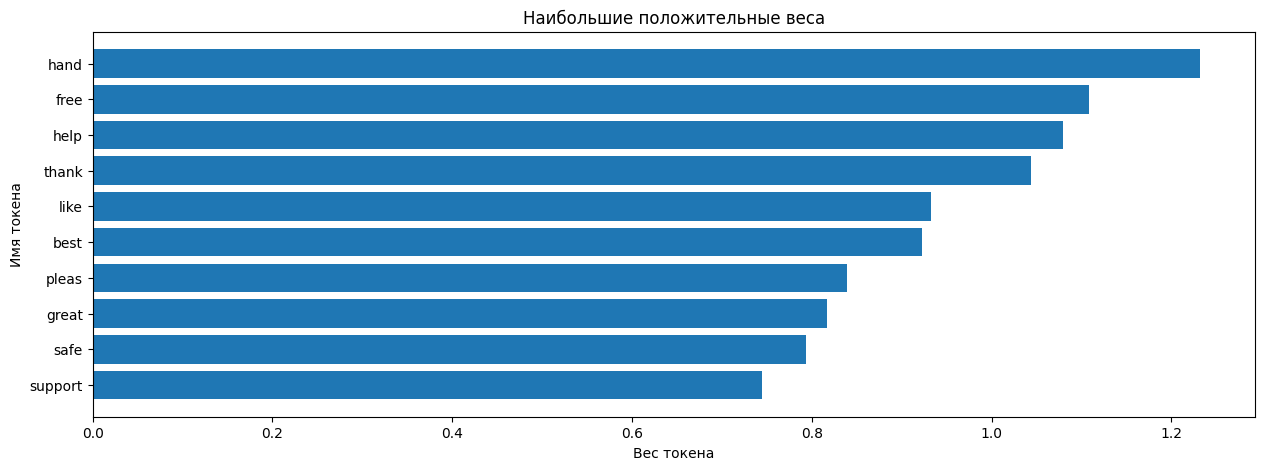

In [179]:
coefs = scaled_lr.coef_[0]
pos_coefs = coefs.argsort()[-10:]
tokens = [cv_df.get_feature_names_out()[idx] for idx in pos_coefs]

plt.figure(figsize=(15, 5))
plt.barh(tokens, coefs[pos_coefs])
plt.xlabel("Вес токена")
plt.ylabel("Имя токена")
plt.title("Наибольшие положительные веса")
plt.show()

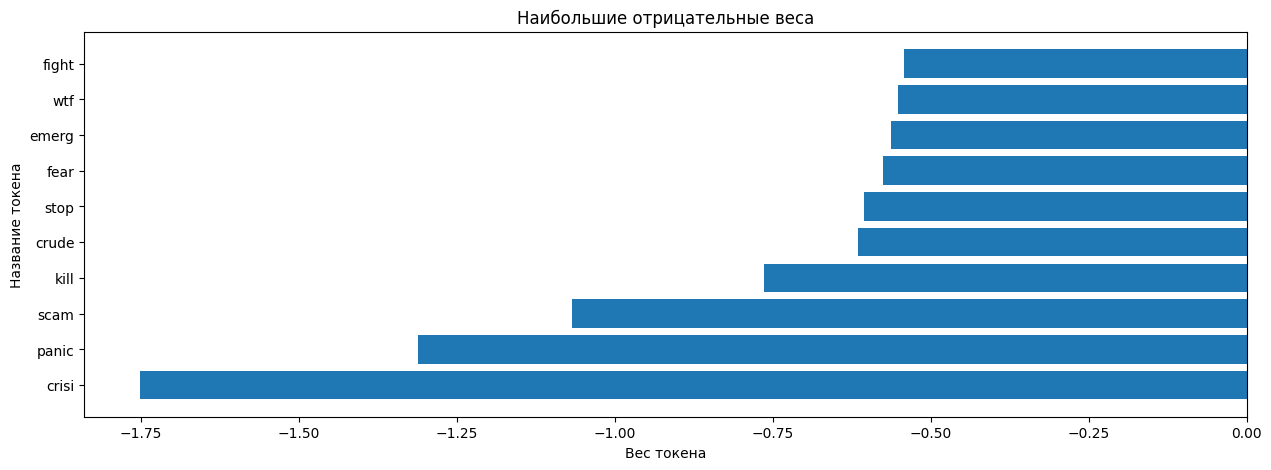

In [180]:
coefs = scaled_lr.coef_[0]
neg_coefs = coefs.argsort()[:10]
tokens = [cv_df.get_feature_names_out()[i] for i in neg_coefs]

plt.figure(figsize=(15, 5))
plt.barh(tokens, coefs[neg_coefs])
plt.xlabel("Вес токена")
plt.ylabel("Название токена")
plt.title("Наибольшие отрицательные веса")
plt.show()

**Ответ:** **токены с максимальным положительным весом указывают на положительность отзывов, так как это слова-комплименты, в то время как токены с отрицательными весами на отрицательные твиты.**

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [181]:
pd.DataFrame(train['UserName'].head(5))

,UserName
25621,35178
30135,40819
28899,39249
5989,11068
4367,9109


In [182]:
pd.DataFrame(train['ScreenName'].head(5))

,ScreenName
25621,80130
30135,85771
28899,84201
5989,56020
4367,54061


**Ответ:** **признаки UserName и ScreenName представляют собой закодированные имена пользователей, представленные целыми числами, причем все значения - уникальны. Эти данные никак не могут помочь определить окраску твита, ведь любой человек может написать как положительный, так и отрицательный отзыв.**

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [183]:
pd.DataFrame(train['TweetAt'].head(5))

,TweetAt
25621,06-04-2020
30135,10-04-2020
28899,09-04-2020
5989,19-03-2020
4367,18-03-2020


In [184]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='mixed')

In [185]:
pd.DataFrame(train['TweetAt'].head(5))

,TweetAt
25621,2020-06-04
30135,2020-10-04
28899,2020-09-04
5989,2020-03-19
4367,2020-03-18


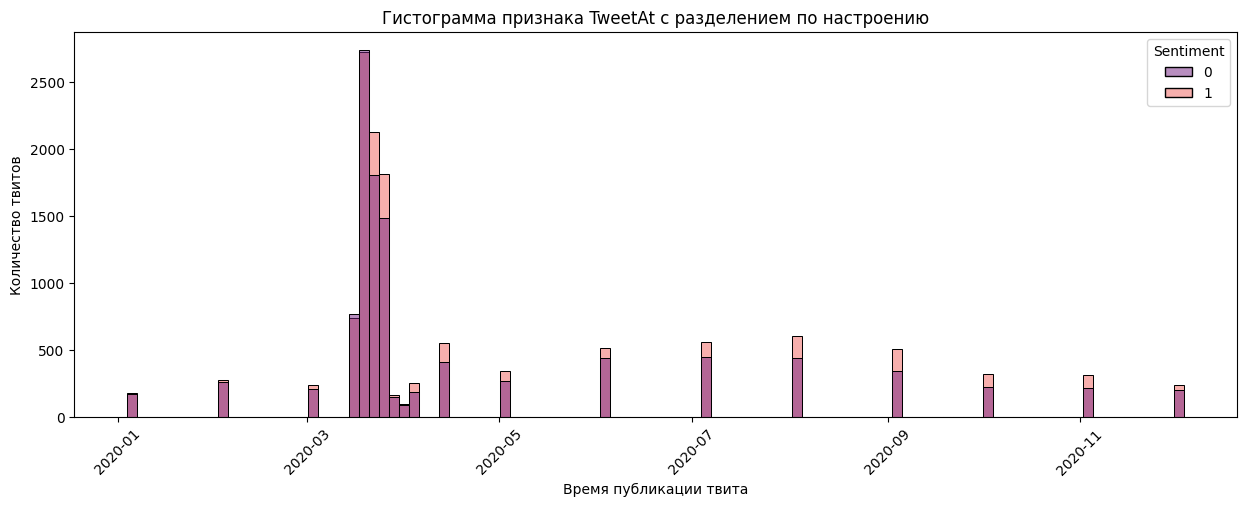

In [186]:
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', palette='magma')
plt.xlabel('Время публикации твита')
plt.xticks(rotation=45)
plt.ylabel('Количество твитов')
plt.title('Гистограмма признака TweetAt с разделением по настроению')
plt.show()

In [187]:
tweet_at_train = pd.get_dummies(train['TweetAt'])
tweet_at_test = pd.get_dummies(test['TweetAt'])

X_train_cv_tweet_at = np.concatenate((X_train_scaled.toarray(), tweet_at_train), axis=1)
X_test_cv_tweet_at = np.concatenate((X_test_scaled.toarray(), tweet_at_test), axis=1)

In [188]:
tweetAt_lr = LogisticRegression(max_iter=1000)
tweetAt_lr.fit(X_train_cv_tweet_at, y_train)

accuracy_train = accuracy_score(y_train, tweetAt_lr.predict(X_train_cv_tweet_at))
accuracy_test = accuracy_score(y_test, tweetAt_lr.predict(X_test_cv_tweet_at))

print("TweetAt")
print("Доля правильных ответов на обучающих данных:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовых данных:", np.round(accuracy_test, 3))

TweetAt
Доля правильных ответов на обучающих данных: 0.943
Доля правильных ответов на тестовых данных: 0.843


**Ответ:** **как видно на гистограмме, в любое время были, как положительные, так и отрицательные твиты, это подтверждается и качеством модели, которые не улучшилось при добавлении данного признака.**



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [189]:
print(f"Количество уникальных значений признака 'Location' на обучающей выборке: {train['Location'].nunique()}")

Количество уникальных значений признака 'Location' на обучающей выборке: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

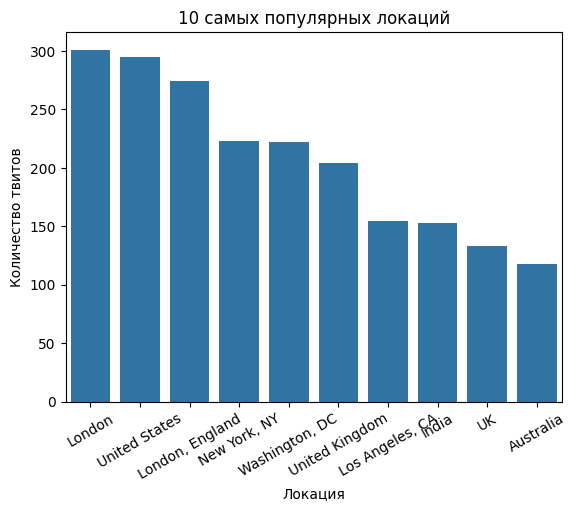

In [190]:
train_filtered = train[train['Location'] != 'Unknown']

popular_locations = train_filtered['Location'].value_counts().head(10)

sns.barplot(x=popular_locations.index, y=popular_locations.values)
plt.xlabel('Локация')
plt.ylabel('Количество твитов')
plt.title('10 самых популярных локаций')
plt.xticks(rotation=30)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [191]:
import re

train['WiderLocation'] = train['Location'].apply(lambda x: re.findall(r'[^,]+[^,]*$', x) if re.findall(r'[^,]+[^,]*$', x) else [x])

train['WiderLocation'] = train['WiderLocation'].apply(lambda x: x[0])

test['WiderLocation'] = test['Location'].apply(lambda x: re.findall(r'[^,]+[^,]*$', x) if re.findall(r'[^,]+[^,]*$', x) else [x])

test['WiderLocation'] = test['WiderLocation'].apply(lambda x: x[0])

In [192]:
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation
25621,35178,80130,Unknown,2020-06-04,Why we still want to buy so much stuff during ...,1,Unknown
30135,40819,85771,"Boston, MA HQ",2020-10-04,With driving even more usage a strong strategy...,1,MA HQ
28899,39249,84201,India,2020-09-04,@Canon_India I am very happy.. Great job by @C...,1,India
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0,UK
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1,WNC


In [193]:
print(f"Количество уникальных значений признака 'WiderLocation' на обучающей выборке: {train['WiderLocation'].nunique()}")

Количество уникальных значений признака 'WiderLocation' на обучающей выборке: 5167


Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [194]:
from sklearn.impute import SimpleImputer
print('Есть ли в датасете пропуски?', "Да" if np.any(train['WiderLocation'].isna().values) else "Нет")
train_filtered = train[train['WiderLocation'] != 'Unknown']
location_counts_train = train_filtered['WiderLocation'].value_counts()
top_locations_train = location_counts_train[location_counts_train > 1].index

print(f"Значений, который не являются 'Unknown' и встречаются более одного раза: {len(top_locations_train)}")

Есть ли в датасете пропуски? Нет
Значений, который не являются 'Unknown' и встречаются более одного раза: 1157


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [195]:
from sklearn.preprocessing import OneHotEncoder

test_filtered = test[test['WiderLocation'] != 'Unknown']
encoder = OneHotEncoder(categories=[top_locations_train], handle_unknown='ignore')
wider_location_ohe_train = encoder.fit_transform(train_filtered['WiderLocation'].values.reshape(-1, 1))
wider_location_ohe_test = encoder.transform(test_filtered['WiderLocation'].values.reshape(-1, 1))

In [196]:
X_train_cv_tweet_at = pd.concat([pd.DataFrame(X_train_scaled.toarray()), pd.DataFrame(wider_location_ohe_train.toarray(), columns=encoder.get_feature_names_out())], axis=1)
X_train_cv_tweet_at.columns = X_train_cv_tweet_at.columns.astype(str)
X_train_cv_tweet_at.fillna(method='ffill', inplace=True)

X_test_cv_tweet_at = pd.concat([pd.DataFrame(X_test_scaled.toarray()), pd.DataFrame(wider_location_ohe_test.toarray(), columns=encoder.get_feature_names_out())], axis=1)
X_test_cv_tweet_at.columns = X_test_cv_tweet_at.columns.astype(str)
X_test_cv_tweet_at.fillna(method='ffill', inplace=True)
tweetAt_lr = LogisticRegression(max_iter=1000)
tweetAt_lr.fit(X_train_cv_tweet_at, y_train)

accuracy_train = accuracy_score(y_train, tweetAt_lr.predict(X_train_cv_tweet_at))
accuracy_test = accuracy_score(y_test, tweetAt_lr.predict(X_test_cv_tweet_at))

print("TweetAt")
print("Доля правильных ответов на обучающих данных:", np.round(accuracy_train, 3))
print("Доля правильных ответов на тестовых данных:", np.round(accuracy_test, 3))

TweetAt
Доля правильных ответов на обучающих данных: 0.946
Доля правильных ответов на тестовых данных: 0.842


**Ответ:** **локация, откуда был написан твит также не позволила улучшить результаты, ведь из любого места может быть написан, как позитивный, так и негативный отзыв.**

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --